In [54]:
# ---------------------------
# Step 1: Import Libraries
# ---------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import xgboost

# Scikit-learn for preprocessing, modeling, and evaluation
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

# Resampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Explainability
import shap

In [57]:
import warnings
warnings.filterwarnings('ignore')

In [58]:
# Set plotting style
plt.style.use('ggplot')

In [104]:
# ---------------------------
# Step 1.1: Set Random Seed
# ---------------------------
import random
import os
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# For scikit-learn
from sklearn.utils import check_random_state
check_random_state(SEED)

RandomState(MT19937) at 0x7C3DA6A12E40

In [59]:
# ---------------------------
# Step 2: Load the Dataset
# ---------------------------
file_path = "/content/Dataset.xlsx"  # Make sure this matches the file path in your Colab instance
df = pd.read_excel(file_path)

In [60]:
# ---------------------------
# Step 3: Data Cleaning
# ---------------------------
print("\nCleaning data...")
# Combine TERMINATED, WITHDRAWN, and SUSPENDED into NOT COMPLETED
df['Study Status'] = df['Study Status'].replace({'TERMINATED': 'NOT COMPLETED',
                                                 'WITHDRAWN': 'NOT COMPLETED',
                                                 'SUSPENDED': 'NOT COMPLETED'})


Cleaning data...


In [61]:
# Map Study Type to numeric values
df['Study Type'] = df['Study Type'].replace({'INTERVENTIONAL': 1, 'OBSERVATIONAL': 2}).astype(int)

In [62]:
# Normalize date formats and compute duration in days
def normalize_date_format(date_str):
    try:
        if len(str(date_str)) == 7:  # YYYY-MM format
            return f"{date_str}-01"
        return str(date_str)
    except Exception:
        return np.nan

In [63]:
df['Completion Date'] = df['Completion Date'].apply(normalize_date_format)
df['Completion Date'] = pd.to_datetime(df['Completion Date'], errors='coerce')
df['Start Date'] = pd.to_datetime(df['Start Date'], errors='coerce')
df['Duration_Days'] = (df['Completion Date'] - df['Start Date']).dt.days.fillna(-1)

In [64]:
# Handle missing values
imputer = KNNImputer(n_neighbors=5)
df['Enrollment'] = imputer.fit_transform(df[['Enrollment']])

In [65]:
# Fill remaining missing values
df['Phases'] = df['Phases'].fillna('Unknown')
df['Sex'] = df['Sex'].fillna('ALL')
df['Primary Outcome Measures'] = df['Primary Outcome Measures'].fillna('Unknown')
df['Secondary Outcome Measures'] = df['Secondary Outcome Measures'].fillna('Unknown')
df['Interventions'] = df['Interventions'].fillna('Unknown')

In [66]:
# Drop irrelevant columns
columns_to_drop = ['Other Outcome Measures', 'Collaborators', 'Results First Posted',
                   'Locations', 'Primary Completion Date']

# Drop these columns from the DataFrame
df.drop(columns_to_drop, axis=1, inplace=True)

# Confirm the columns have been dropped
print("\nRemaining Missing Values:")
print(df.isna().sum())


Remaining Missing Values:
NCT Number                    0
Study Title                   0
Study URL                     0
Study Status                  0
Brief Summary                 0
Study Results                 0
Conditions                    0
Interventions                 0
Primary Outcome Measures      0
Secondary Outcome Measures    0
Sponsor                       0
Sex                           0
Age                           0
Phases                        0
Enrollment                    0
Funder Type                   0
Study Type                    0
Study Design                  0
Other IDs                     0
Start Date                    0
Completion Date               1
First Posted                  0
Last Update Posted            0
Duration_Days                 0
dtype: int64


In [67]:
# Fill missing 'Completion Date' based on 'Start Date' and 'Duration_Days'
df['Completion Date'] = df.apply(
    lambda row: row['Start Date'] + pd.Timedelta(days=row['Duration_Days'])
    if pd.isna(row['Completion Date']) and not pd.isna(row['Start Date'])
    else row['Completion Date'], axis=1
)

# Verify if there are still missing values
print("\nRemaining Missing Values After Imputation:")
print(df.isna().sum())


Remaining Missing Values After Imputation:
NCT Number                    0
Study Title                   0
Study URL                     0
Study Status                  0
Brief Summary                 0
Study Results                 0
Conditions                    0
Interventions                 0
Primary Outcome Measures      0
Secondary Outcome Measures    0
Sponsor                       0
Sex                           0
Age                           0
Phases                        0
Enrollment                    0
Funder Type                   0
Study Type                    0
Study Design                  0
Other IDs                     0
Start Date                    0
Completion Date               0
First Posted                  0
Last Update Posted            0
Duration_Days                 0
dtype: int64


In [68]:
# ---------------------------
# Step 4: Feature Engineering
# ---------------------------
print("\nEngineering features...")
# Add binary features
df['Binary_Values'] = (df['Enrollment'] >= 50).astype(int)
df['Participants'] = df['Enrollment'] - df.get('count', pd.Series([0] * len(df)))


Engineering features...


In [69]:
# Scale numerical features
scaler = StandardScaler()
numerical_features = ['Enrollment', 'Duration_Days']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [70]:
# Encode categorical features
label_encoder = LabelEncoder()
categorical_columns = ['Funder Type', 'Phases', 'Sex']
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

In [71]:
# Drop text-based columns irrelevant for modeling
columns_to_drop = ['Study Title', 'Brief Summary', 'Study Results',
                   'Conditions', 'Interventions', 'Primary Outcome Measures',
                   'Secondary Outcome Measures', 'Sponsor', 'Other IDs']
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)


Visualizing correlations...


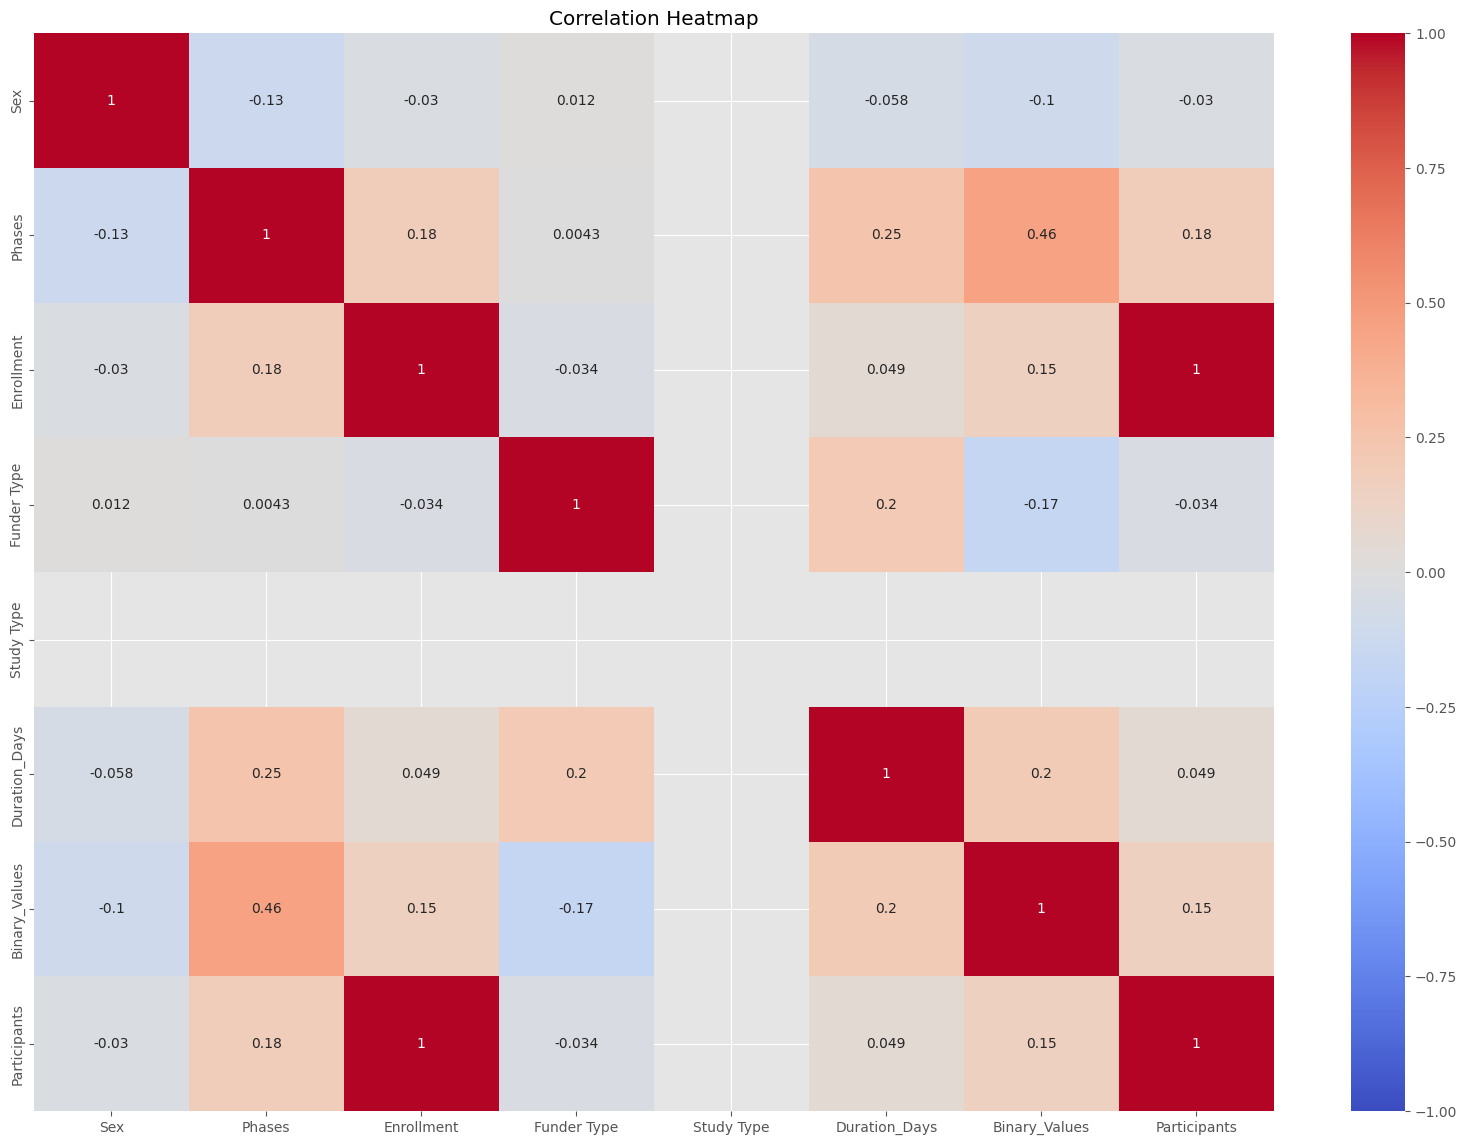

In [72]:
# ---------------------------
# Step 5: Correlation Heatmap
# ---------------------------

# Filter numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=['number'])

print("\nVisualizing correlations...")
plt.figure(figsize=(20, 14))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

In [73]:
# ---------------------------
# Step 6: Train-Test Split
# ---------------------------
# Map target variable to binary
df['Study Status'] = df['Study Status'].map({'COMPLETED': 1, 'NOT COMPLETED': 0})

In [74]:
# Split features and target
X = df.drop('Study Status', axis=1)
y = df['Study Status']

In [75]:
y.fillna(y.mode()[0], inplace=True)

In [76]:
X.drop(['NCT Number', 'Study URL'], axis=1, inplace=True)

In [77]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
categorical_columns = ['Age', 'Study Design']

for col in categorical_columns:
    X[col] = label_encoder.fit_transform(X[col])

In [78]:
from datetime import datetime

reference_date = datetime(2000, 1, 1)  # Example reference date
datetime_columns = ['Start Date', 'Completion Date', 'First Posted', 'Last Update Posted']

for col in datetime_columns:
    X[col] = (X[col] - reference_date).dt.days

In [79]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

In [80]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

In [81]:
# ---------------------------
# Step 7: Hyperparameter Tuning
# ---------------------------
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

In [82]:
rf_model = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=3, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)
print("\nBest Parameters for Random Forest:", grid_search_rf.best_params_)


Best Parameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [84]:
# ---------------------------
# Step 8: Feature Selection and PCA
# ---------------------------
rfe = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=10)
rfe.fit(X_train, y_train)
selected_features = X_train.columns[rfe.support_]
print("\nSelected Features:", selected_features)


Selected Features: Index(['Phases', 'Enrollment', 'Study Design', 'Start Date', 'Completion Date',
       'First Posted', 'Last Update Posted', 'Duration_Days', 'Binary_Values',
       'Participants'],
      dtype='object')


In [85]:
# PCA for dimensionality reduction
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [86]:
# ---------------------------
# Step 9: Model Training and Evaluation
# ---------------------------
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    print("Accuracy:", accuracy_score(y, y_pred))
    print("Classification Report:\n", classification_report(y, y_pred))
    conf_matrix = confusion_matrix(y, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model.__class__.__name__}')
    plt.show()


Training RandomForestClassifier...
Accuracy: 0.8191721132897604
Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.86      0.82       456
         1.0       0.85      0.78      0.81       462

    accuracy                           0.82       918
   macro avg       0.82      0.82      0.82       918
weighted avg       0.82      0.82      0.82       918



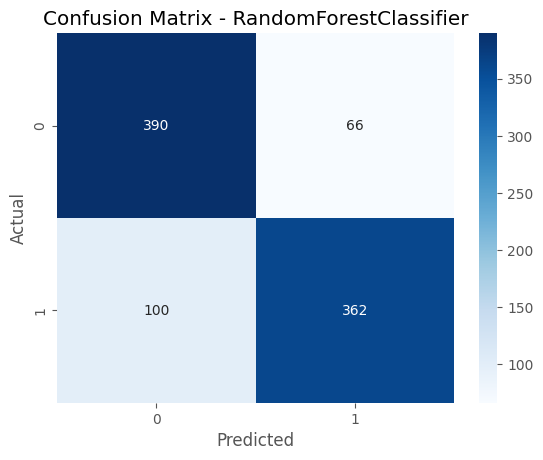


Training GradientBoostingClassifier...
Accuracy: 0.7363834422657952
Classification Report:
               precision    recall  f1-score   support

         0.0       0.72      0.77      0.74       456
         1.0       0.76      0.70      0.73       462

    accuracy                           0.74       918
   macro avg       0.74      0.74      0.74       918
weighted avg       0.74      0.74      0.74       918



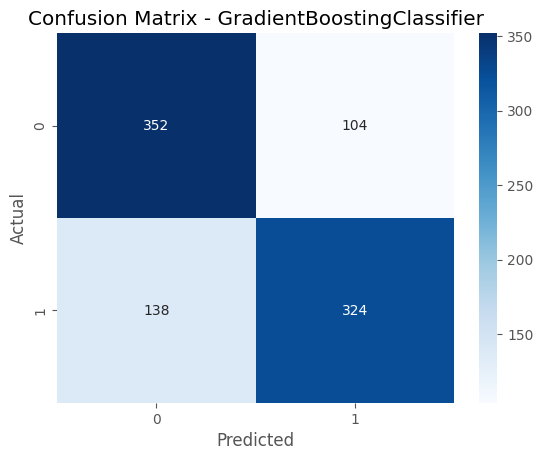


Training LogisticRegression...
Accuracy: 0.6209150326797386
Classification Report:
               precision    recall  f1-score   support

         0.0       0.60      0.70      0.65       456
         1.0       0.65      0.54      0.59       462

    accuracy                           0.62       918
   macro avg       0.62      0.62      0.62       918
weighted avg       0.62      0.62      0.62       918



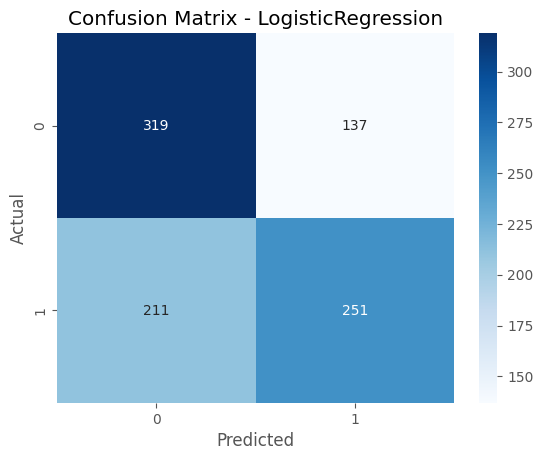


Training LinearSVC...
Accuracy: 0.6154684095860566
Classification Report:
               precision    recall  f1-score   support

         0.0       0.60      0.70      0.64       456
         1.0       0.64      0.53      0.58       462

    accuracy                           0.62       918
   macro avg       0.62      0.62      0.61       918
weighted avg       0.62      0.62      0.61       918



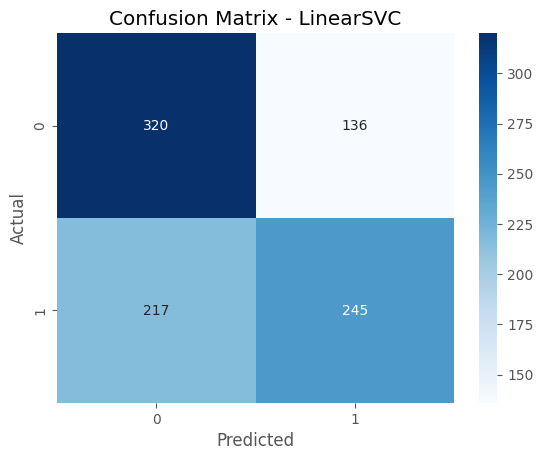

In [87]:
# Train and evaluate models
from sklearn.svm import LinearSVC
# Initialize PCA with the desired number of components (e.g., 10)
pca = PCA(n_components=5, random_state=42)  # Try reducing components further

# Fit PCA on the training data and transform both training and test data
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train_pca, y_train, test_size=0.8, random_state=42
)

models = [
    RandomForestClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
    LogisticRegression(random_state=42),
    LinearSVC(random_state=42, max_iter=1000)  # Faster than SVC with linear kernel
]

for model in models:
    print(f"\nTraining {model.__class__.__name__}...")
    model.fit(X_train_pca, y_train)
    evaluate_model(model, X_test_pca, y_test)

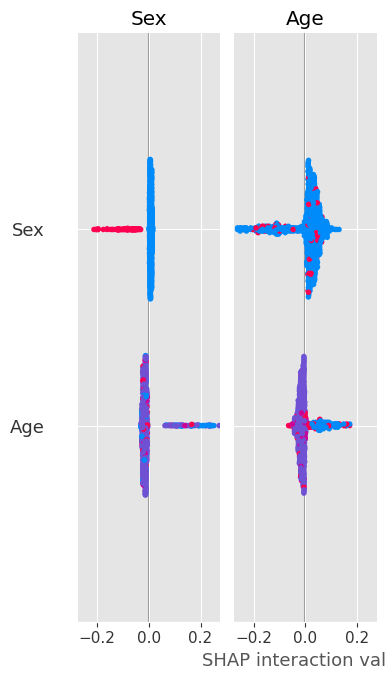

In [88]:
# ---------------------------
# Step 10: Explainability with SHAP
# ---------------------------
shap.initjs()
explainer = shap.TreeExplainer(grid_search_rf.best_estimator_)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [89]:
# ---------------------------
# Step 11: Model Training and Evaluation
# ---------------------------
# Train Random Forest Classifier
print("\nTraining Random Forest...")
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)


Training Random Forest...


RandomForestClassifier(random_state=42)

In [90]:
# Evaluate Random Forest
y_pred = rf_model.predict(X_test)
print("\nRandom Forest Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Random Forest Metrics:
Accuracy: 0.8681917211328976
Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.83      0.86       456
         1.0       0.84      0.90      0.87       462

    accuracy                           0.87       918
   macro avg       0.87      0.87      0.87       918
weighted avg       0.87      0.87      0.87       918



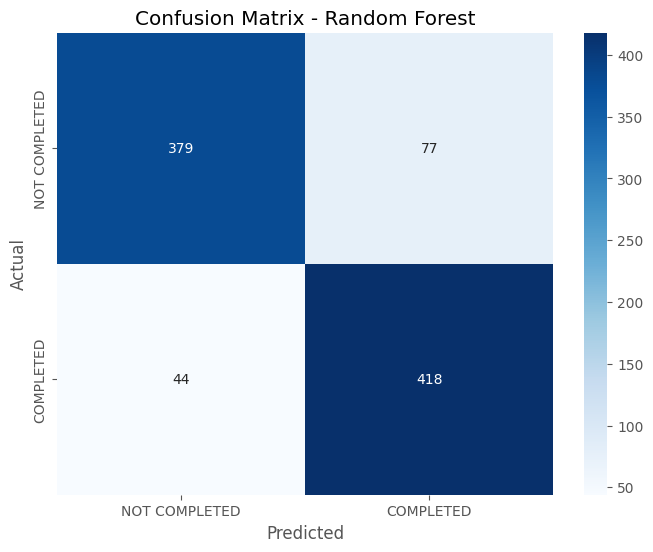

In [91]:
# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['NOT COMPLETED', 'COMPLETED'], yticklabels=['NOT COMPLETED', 'COMPLETED'])
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [92]:
# Feature Importance Plot
print("\nPlotting Feature Importances...")
feature_importances = rf_model.feature_importances_
features = X.columns
sorted_indices = np.argsort(feature_importances)[::-1]


Plotting Feature Importances...


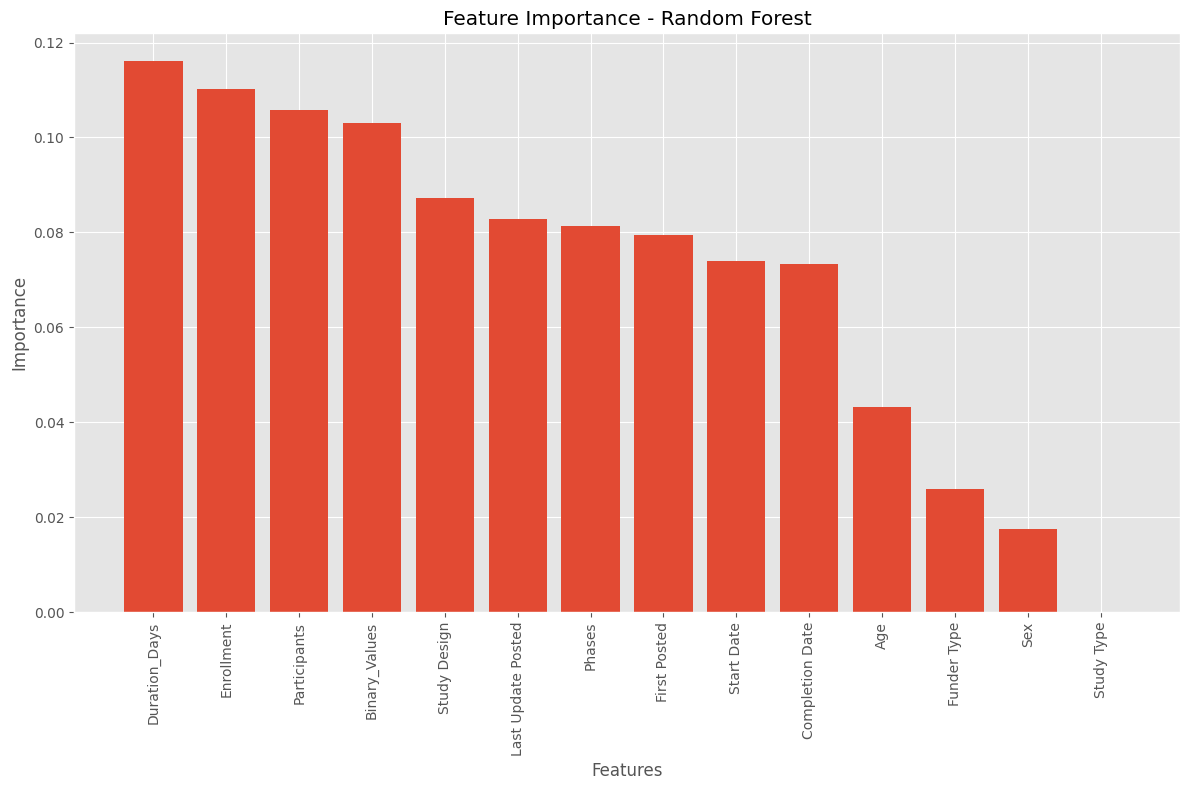

In [93]:
plt.figure(figsize=(12, 8))
plt.bar(range(X.shape[1]), feature_importances[sorted_indices], align='center')
plt.xticks(range(X.shape[1]), features[sorted_indices], rotation=90)
plt.title('Feature Importance - Random Forest')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

In [94]:
# Train Gradient Boosting Classifier
print("\nTraining Gradient Boosting...")
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)


Training Gradient Boosting...


GradientBoostingClassifier(random_state=42)

In [95]:
# Evaluate Gradient Boosting
y_pred_gb = gb_model.predict(X_test)
print("\nGradient Boosting Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Classification Report:\n", classification_report(y_test, y_pred_gb))


Gradient Boosting Metrics:
Accuracy: 0.8148148148148148
Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.77      0.80       456
         1.0       0.79      0.86      0.82       462

    accuracy                           0.81       918
   macro avg       0.82      0.81      0.81       918
weighted avg       0.82      0.81      0.81       918



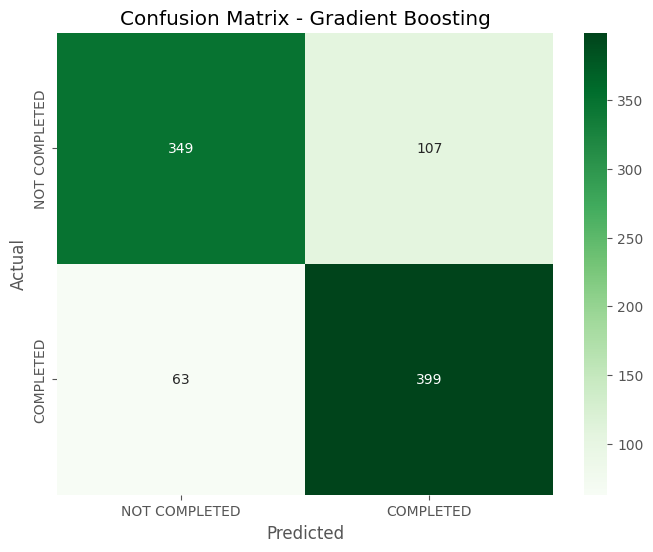

In [96]:
# Plot Confusion Matrix for Gradient Boosting
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_gb, annot=True, fmt='d', cmap='Greens', xticklabels=['NOT COMPLETED', 'COMPLETED'], yticklabels=['NOT COMPLETED', 'COMPLETED'])
plt.title('Confusion Matrix - Gradient Boosting')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Plotting Predicted vs Actual...


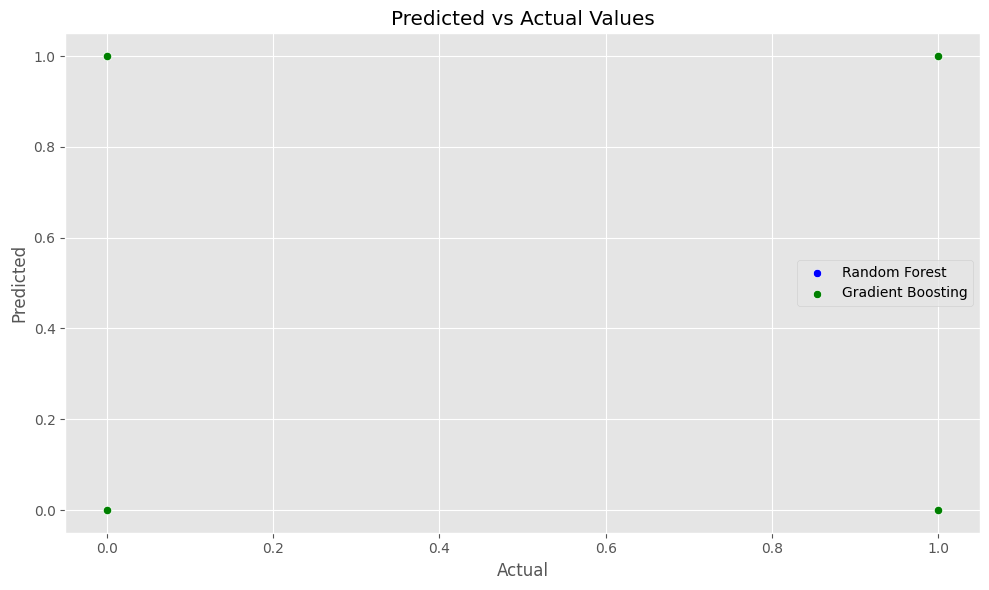

In [97]:
# Predicted vs Actual Plot
print("\nPlotting Predicted vs Actual...")
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, color='blue', label='Random Forest')
sns.scatterplot(x=y_test, y=y_pred_gb, color='green', label='Gradient Boosting')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.tight_layout()
plt.show()

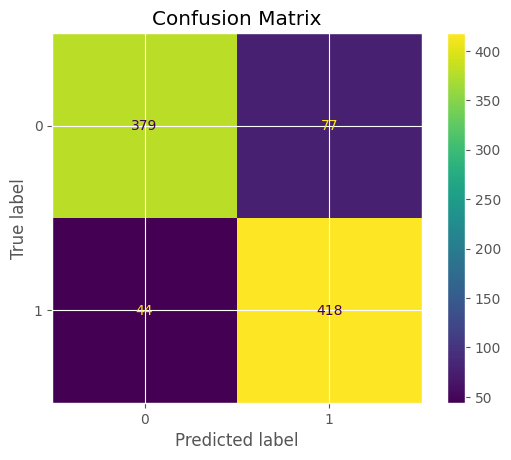

In [98]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title("Confusion Matrix")
plt.show()

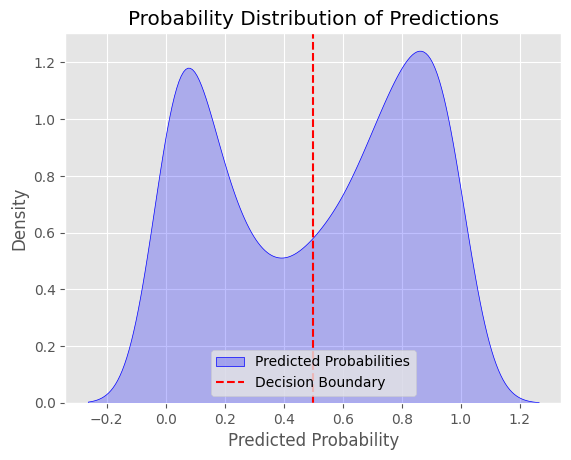

In [99]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (1)

sns.kdeplot(y_pred_proba, label='Predicted Probabilities', color='blue', fill=True)
plt.axvline(0.5, color='red', linestyle='--', label='Decision Boundary')
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.legend()
plt.title("Probability Distribution of Predictions")
plt.show()


In [100]:
from sklearn.ensemble import HistGradientBoostingClassifier

ensemble = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(random_state=42)),
        ('gb', GradientBoostingClassifier(random_state=42)),
        ('hgb', HistGradientBoostingClassifier(random_state=42))
    ],
    voting='soft'
)


In [101]:
import numpy as np

# Train individual models
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)
gb = GradientBoostingClassifier(random_state=42).fit(X_train, y_train)
xgb_model = xgb.XGBClassifier(random_state=42).fit(X_train, y_train)

# Predict probabilities
rf_probs = rf.predict_proba(X_test)
gb_probs = gb.predict_proba(X_test)
xgb_probs = xgb_model.predict_proba(X_test)

# Average probabilities
avg_probs = np.mean([rf_probs, gb_probs, xgb_probs], axis=0)

# Final predictions
y_pred_ensemble = np.argmax(avg_probs, axis=1)


In [102]:
# ---------------------------
# Step 12: Save Preprocessed Data
# ---------------------------
df.to_csv("preprocessed_clinical_trials.csv", index=False)
print("\nPreprocessed data saved.")


Preprocessed data saved.
